In [1]:
# -*- coding: utf-8 -*-

# From the Meep tutorial: plotting permittivity and fields of a bent waveguide
from __future__ import division

import meep as mp
import matplotlib.pyplot as plt

cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),
                     center=mp.Vector3(-2.5,-3.5),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                     center=mp.Vector3(3.5,2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

vals = []

def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0,-3.5), size=mp.Vector3(16,0), component=mp.Ez))

sim.run(mp.at_every(0.6, get_slice),
        until=200)

-----------
Initializing structure...
run 0 finished at t = 200.0 (4000 timesteps)


(-0.5, 159.5, 332.5, -0.5)

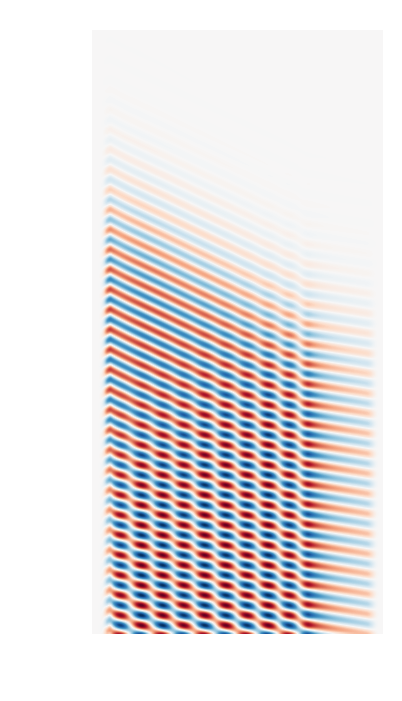

In [2]:
plt.figure(dpi=200)
plt.imshow(vals, interpolation='spline36', cmap='RdBu')
plt.axis('off')